In [217]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from scipy.stats import probplot
import seaborn as sns
import sklearn
import collections
import operator
import warnings
warnings.filterwarnings('ignore')

In [218]:
data = pd.HDFStore('stocks.hdf')

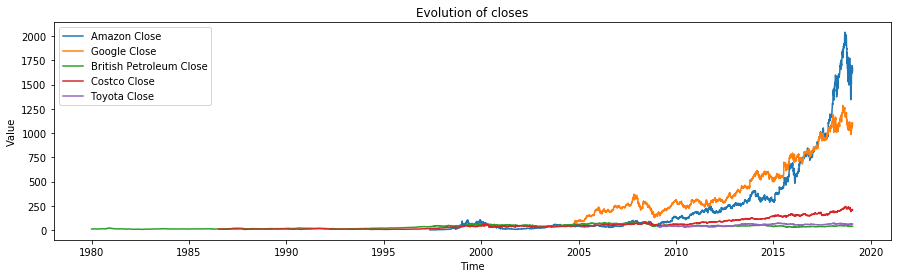

In [219]:
# Testing plots on one stock
plt.figure(figsize=(15,4))
plt.plot(data.AMZN.Close, label='Amazon Close')
plt.plot(data.GOOGL.Close, label='Google Close')
plt.plot(data.BP.Close, label='British Petroleum Close')
plt.plot(data.COST.Close, label='Costco Close')
plt.plot(data.TOYOF.Close, label='Toyota Close')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Evolution of closes')
plt.legend()
plt.show()

### Faire une analyse rapide des returns contruits à partir des Closes ( distribution/Correlation)

In [220]:
def get_returns(table):
    return table['Close'].pct_change()

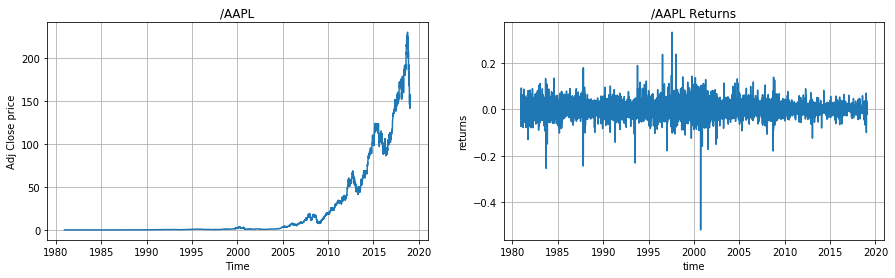

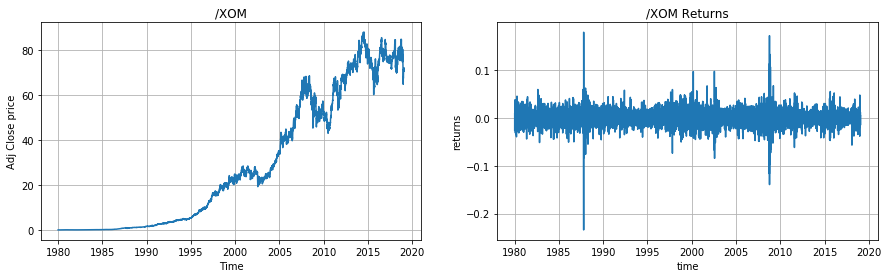

In [221]:
# Use it to plot the returns
def plotting_returns(table):
    plt.figure(figsize=(15,4))
    ax = plt.subplot2grid((1, 2), (0,0))
    ax.plot(data[table]['Adj Close'])
    ax.grid(True)
    ax.set_title(table)
    ax.set_xlabel('Time')
    ax.set_ylabel('Adj Close price')

    ax = plt.subplot2grid((1, 2), (0,1))
    ax.plot(data[table].index, get_returns(data[table]))
    ax.grid(True)
    ax.set_title('{} Returns'.format(table))
    ax.set_xlabel('time')
    ax.set_ylabel('returns')
    plt.show()


plotting_returns('/AAPL')
plotting_returns('/XOM')

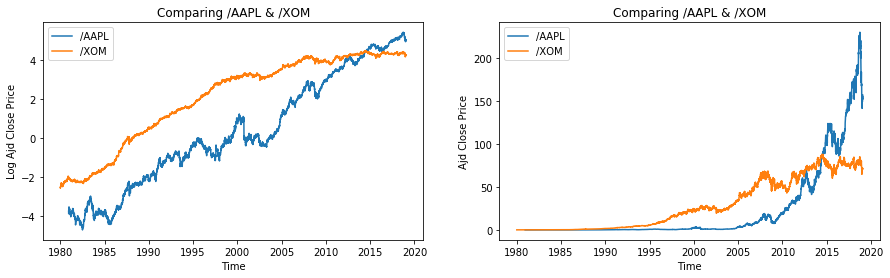

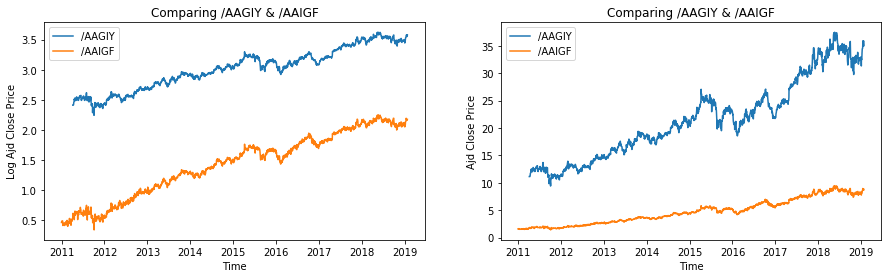

In [222]:
def plotting_closes(tables):
    plt.figure(figsize=(15,4))
    ax = plt.subplot2grid((1, 2), (0,0))
    ax.plot(np.log(data[tables[0]]['Adj Close']), label=tables[0])
    ax.plot(np.log(data[tables[1]]['Adj Close']), label=tables[1])
    ax.set_title('Comparing {} & {}'.format(tables[0],tables[1]))
    ax.set_xlabel('Time')
    ax.set_ylabel('Log Ajd Close Price')
    ax.legend()

    ax = plt.subplot2grid((1, 2), (0,1))
    ax.plot(data[tables[0]]['Adj Close'], label=tables[0])
    ax.plot(data[tables[1]]['Adj Close'], label=tables[1])
    ax.set_title('Comparing {} & {}'.format(tables[0], tables[1]))
    ax.set_xlabel('Time')
    ax.set_ylabel('Ajd Close Price')
    ax.legend()

    plt.show()
    
plotting_closes(['/AAPL', '/XOM'])
plotting_closes(list(data.keys())[0:2])

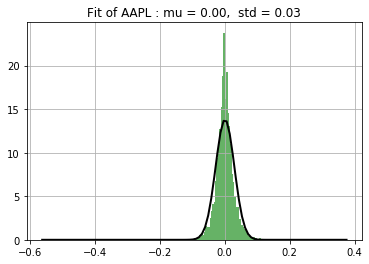

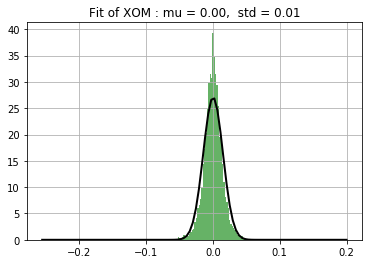

Metrics for AAPL:
kurtosis: 18.071012283793422
skew: -0.38527035136977955


Metrics for XOM:
kurtosis: 15.609060542851827
skew: -0.03631671015621176


In [223]:
# Compute distribution
import scipy
from scipy.stats import norm

# Distribution

def fitgauss(ret,name='distrib to fit'):
    mu, std = norm.fit(ret.dropna())
    ret.dropna().hist(bins=200, density=True, alpha=0.6, color='g')
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit of "+str(name)+" : mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    return x,p

fitgauss(get_returns(data['/AAPL']), name='AAPL')
fitgauss(get_returns(data['/XOM']), name='XOM')

def metric(ret):
    print("kurtosis: "+str(ret.kurtosis())+"\n"+"skew: "+str(ret.skew()))
    
print('Metrics for AAPL:')
metric(get_returns(data['/AAPL']))

print('\n')

print('Metrics for XOM:')

metric(get_returns(data['/XOM']))

# Construire une bases de returns proprement normalisée

### Etude des valeurs extrêmes et des corrélations

In [224]:
# Get longest dataframe
def get_longest():
    lens = {}
    for table in data.keys():
        lens[table] = len(data[table]['Close'])
    return max(lens.items(), key=operator.itemgetter(1))

def get_smallest():
    lens = {}
    for table in data.keys():
        lens[table] = len(data[table]['Close'])
    return min(lens.items(), key=operator.itemgetter(1))

print(get_longest())
print(get_smallest())

('/BA', 9852)
('/JPM-PD', 76)


In [225]:
# Create closes table
closes = data['/BA']['Close']

list_keys = data.keys()
list_keys.remove('/BA')
list_keys = [name[1:] for name in list_keys]

for table in list_keys:
    closes = pd.merge(closes, data['/{}'.format(table)]['Close'], on="Date", how="outer")

list_keys.insert(0,'BA')

closes.columns = list_keys

print(closes.shape)
closes.head()

(9852, 165)


,BA,AAGIY,AAIGF,AAPL,ABBV,ABT,ACGBF,ACGBY,ACN,ADBE,...,WFC-PP,WFC-PQ,WFC-PR,WFC-PT,WFC-PV,WFC-PW,WFC-PX,WFC-PY,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,4.901235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130859,3.367188
1980-01-03,4.962963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129395,3.281250
1980-01-04,5.444445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.132324,3.312500
1980-01-07,5.641975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.131836,3.296875
1980-01-08,5.728395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134277,3.320312


In [226]:
"""
We make a dataframe of returns
Drop row where all values are NaN
Normalize the dataset
"""

returns = pd.DataFrame()

for col in closes.columns:
    returns[col] = closes[col].pct_change()
    
returns.dropna(how="all", inplace=True)

returns = (returns - returns.mean()) / (returns.std())

returns.tail(5)

,BA,AAGIY,AAIGF,AAPL,ABBV,ABT,ACGBF,ACGBY,ACN,ADBE,...,WFC-PP,WFC-PQ,WFC-PR,WFC-PT,WFC-PV,WFC-PW,WFC-PX,WFC-PY,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-18,0.796954,0.724846,-0.129358,0.177895,1.465768,0.756394,-0.010840,0.350155,0.430440,0.359392,...,2.231415,2.552176,2.637044,4.141568,3.699946,2.515868,1.876171,1.849288,0.540583,0.780463
2019-01-22,-1.021593,-1.762986,-0.697618,-0.812424,-0.575562,0.021555,-0.010840,-1.455936,-0.552428,-0.510882,...,-1.820168,-1.148455,-0.355796,-0.758822,-0.782316,0.453541,0.298988,-0.251401,-0.188281,-1.050920
2019-01-23,0.072198,-0.006435,-0.034902,0.104671,-0.175034,-1.417971,-0.010840,0.675078,-0.230410,0.124209,...,0.243287,1.061048,-0.356506,-0.319661,-0.077741,0.805708,0.390421,0.656211,0.671568,-0.585256
2019-01-24,-0.082648,0.170490,-0.034902,-0.309747,-1.698387,0.807941,-0.010840,0.800161,0.573869,-0.376046,...,2.458077,0.505131,0.633208,1.336708,0.730608,2.210025,2.221891,3.008295,-0.250884,0.066701
2019-01-25,0.841604,1.227769,0.590425,1.111849,-3.589146,0.215675,1.964966,1.535455,0.556367,0.268550,...,2.254183,0.595943,1.315082,0.451028,1.534872,0.098381,1.021139,1.896591,-0.876447,0.275616


In [227]:
# Catching outliers

outliers = []
for table_name in data.keys():
    ret = get_returns(data[table_name])
    mu, std = norm.fit(ret.dropna())
    if std > 0.05:
        print("std {} returns over .05".format(table_name))
        outliers.append(table_name)
    elif mu < -0.01 or mu > 0.01:
        print("mu {} returns different from 0".format(table_name))
        outliers.append(table_name)

std /NAPRF returns over .05
std /SNYNF returns over .05


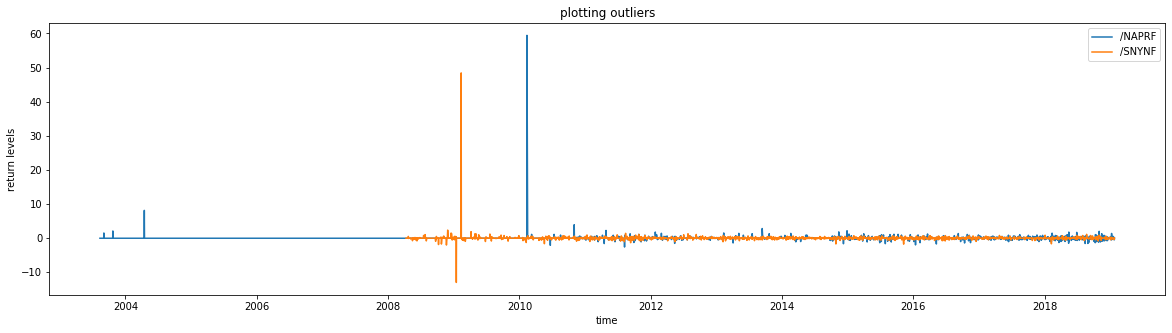

In [228]:
plt.figure(figsize=(20,5))
for series in outliers:
    plt.plot(returns[series[1:]], label=series)
plt.title('plotting outliers')
plt.xlabel('time')
plt.ylabel('return levels')
plt.legend()

plt.show()

#### Analyse des valeurs extrêmes

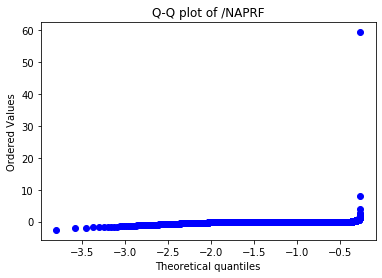

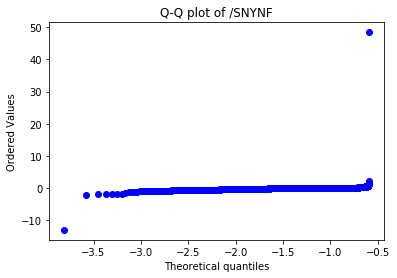

In [229]:
for series in outliers:
    probplot(returns[series[1:]], dist="norm", plot=plt)
    plt.title("Q-Q plot of {}".format(series))
    plt.show()

In [230]:
# PLotting our correlation matrix
def coor_mat(choice='close'):
    # using dato for ['Adj Close'] df_ret for returns
    if choice == 'ret':
        corr = returns.corr()
    elif choice == 'close':
        corr = closes.corr()
    else:
        raise 'Choose between returns ("ret") and closes ("close")\n '
    
    sns.set(style="white")

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(45, 45))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(1000, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Heat map: Correlation between {} series'.format(choice))
    #plt.show()
    if choice == 'ret':
        plt.savefig('imgs/corr_returns.png')
    else:
        plt.savefig('imgs/corr_closes.png')

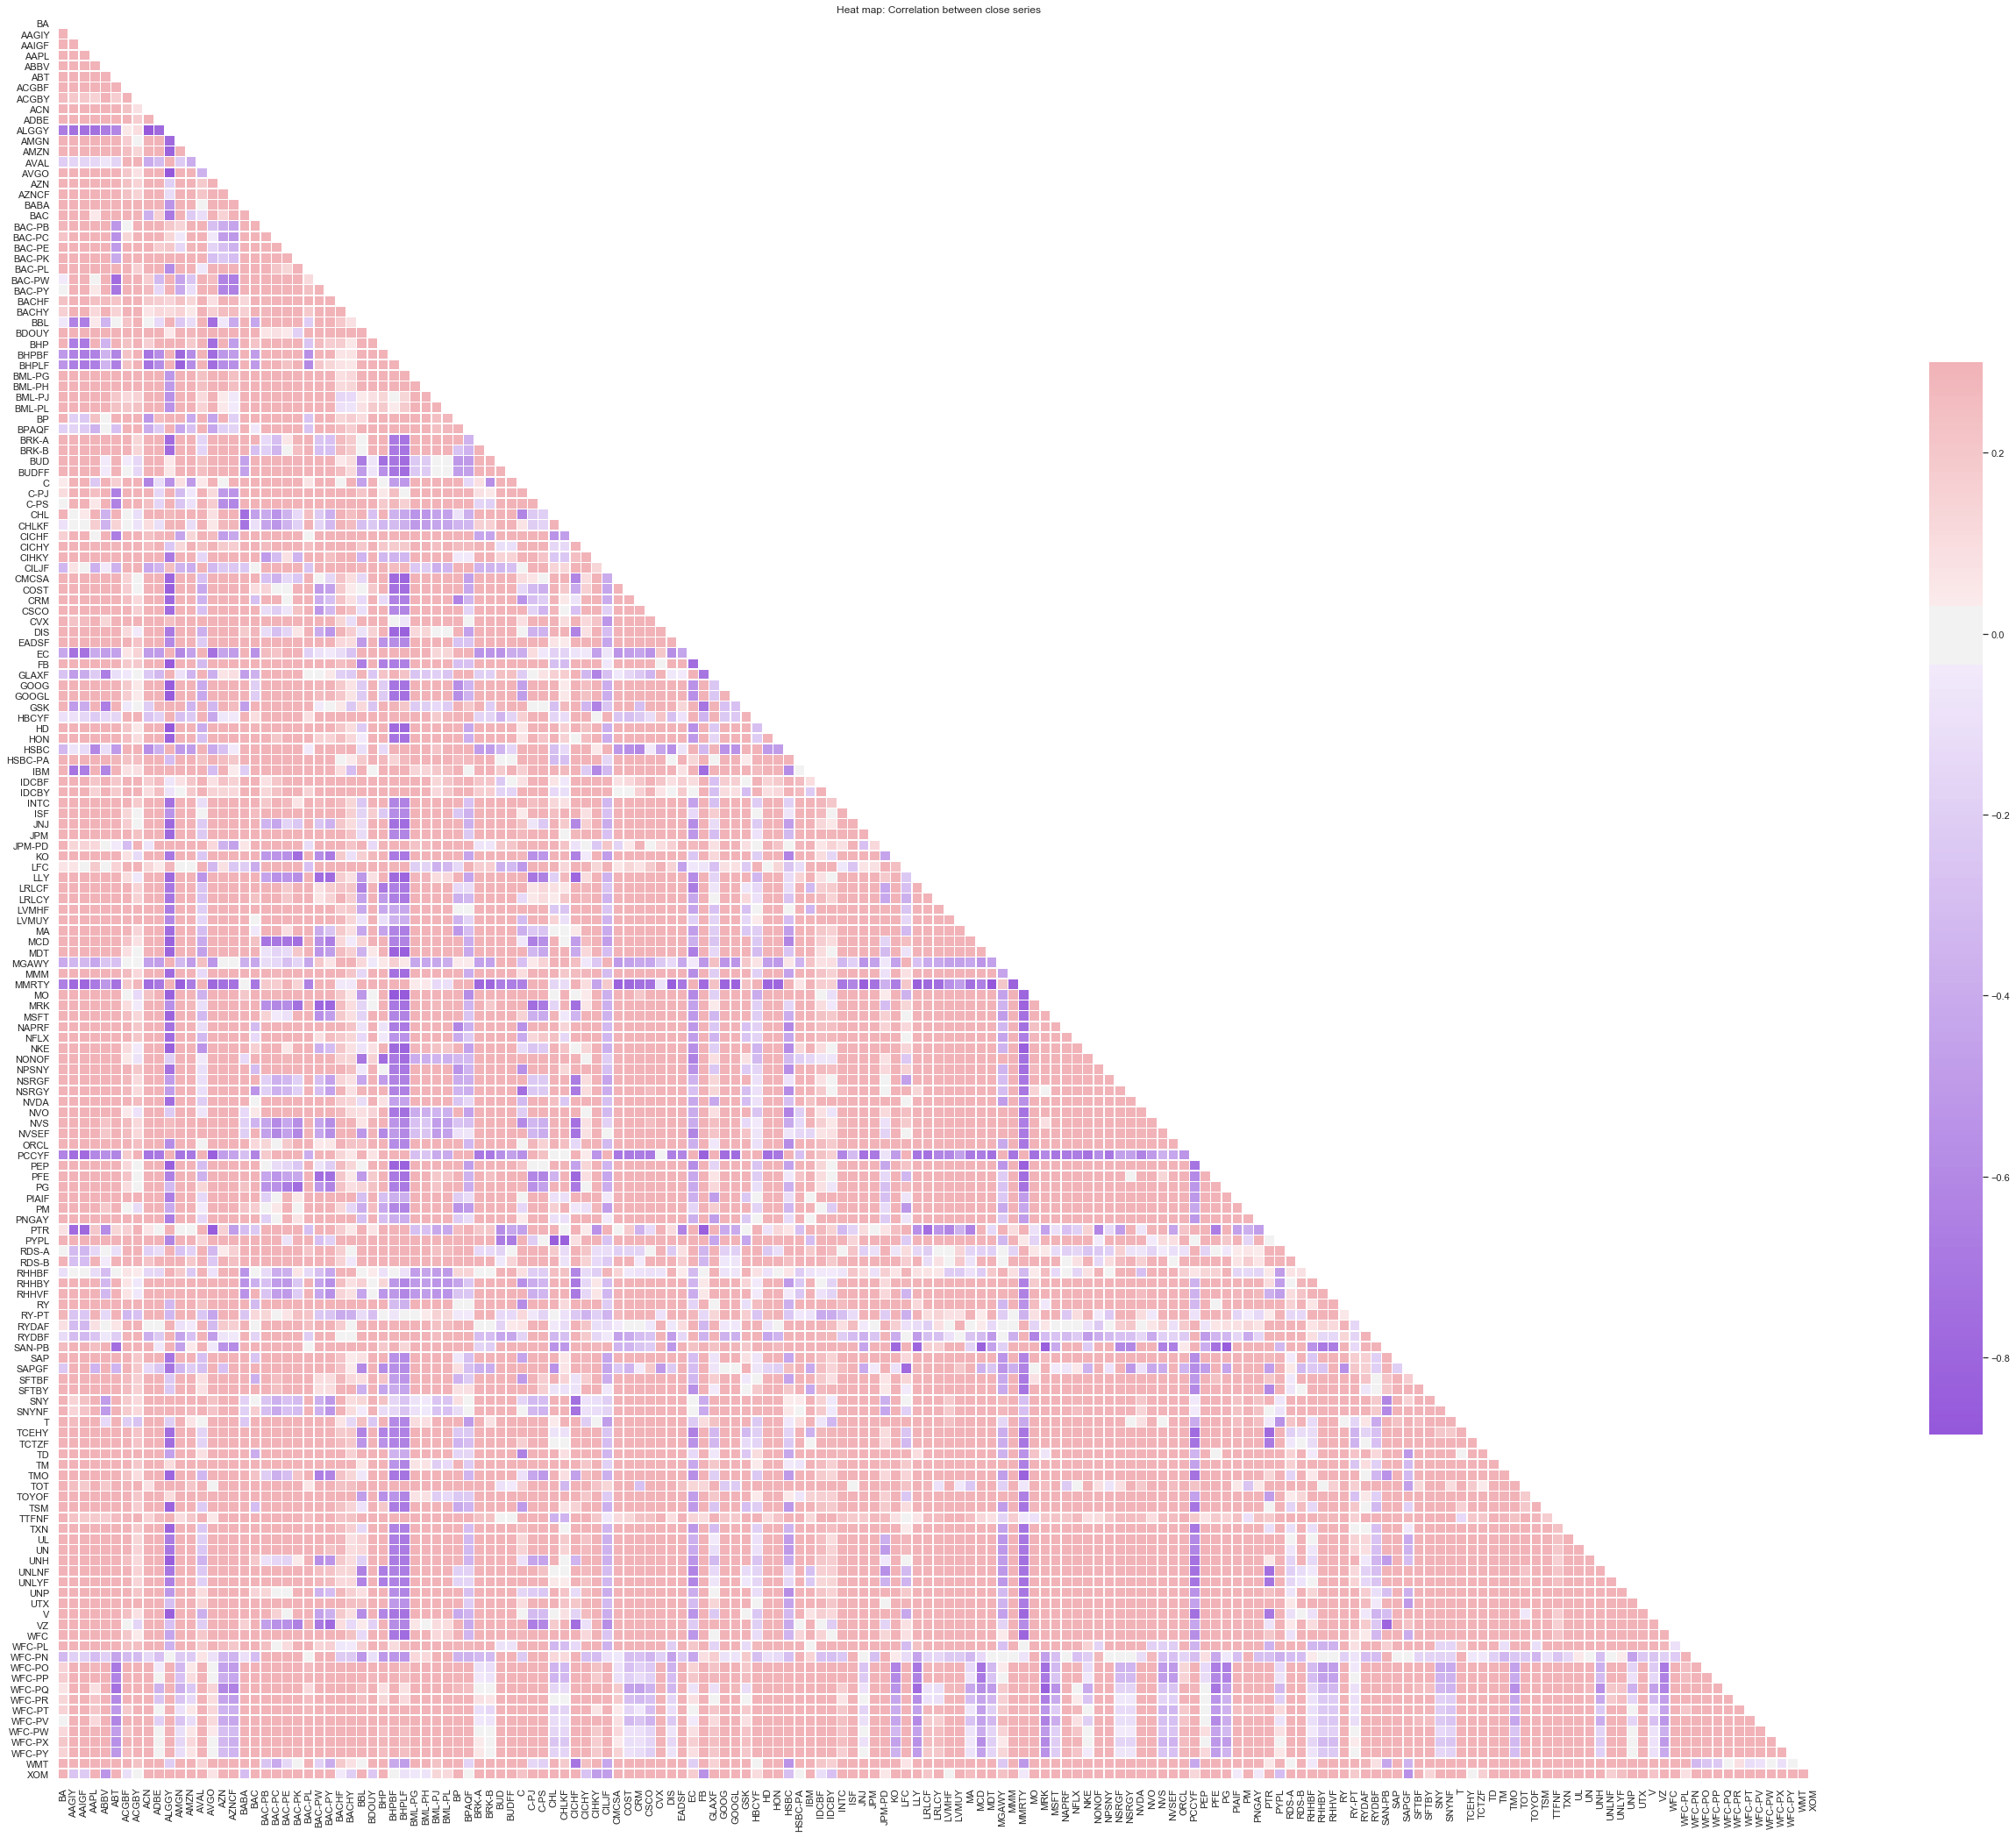

In [231]:
coor_mat('close')

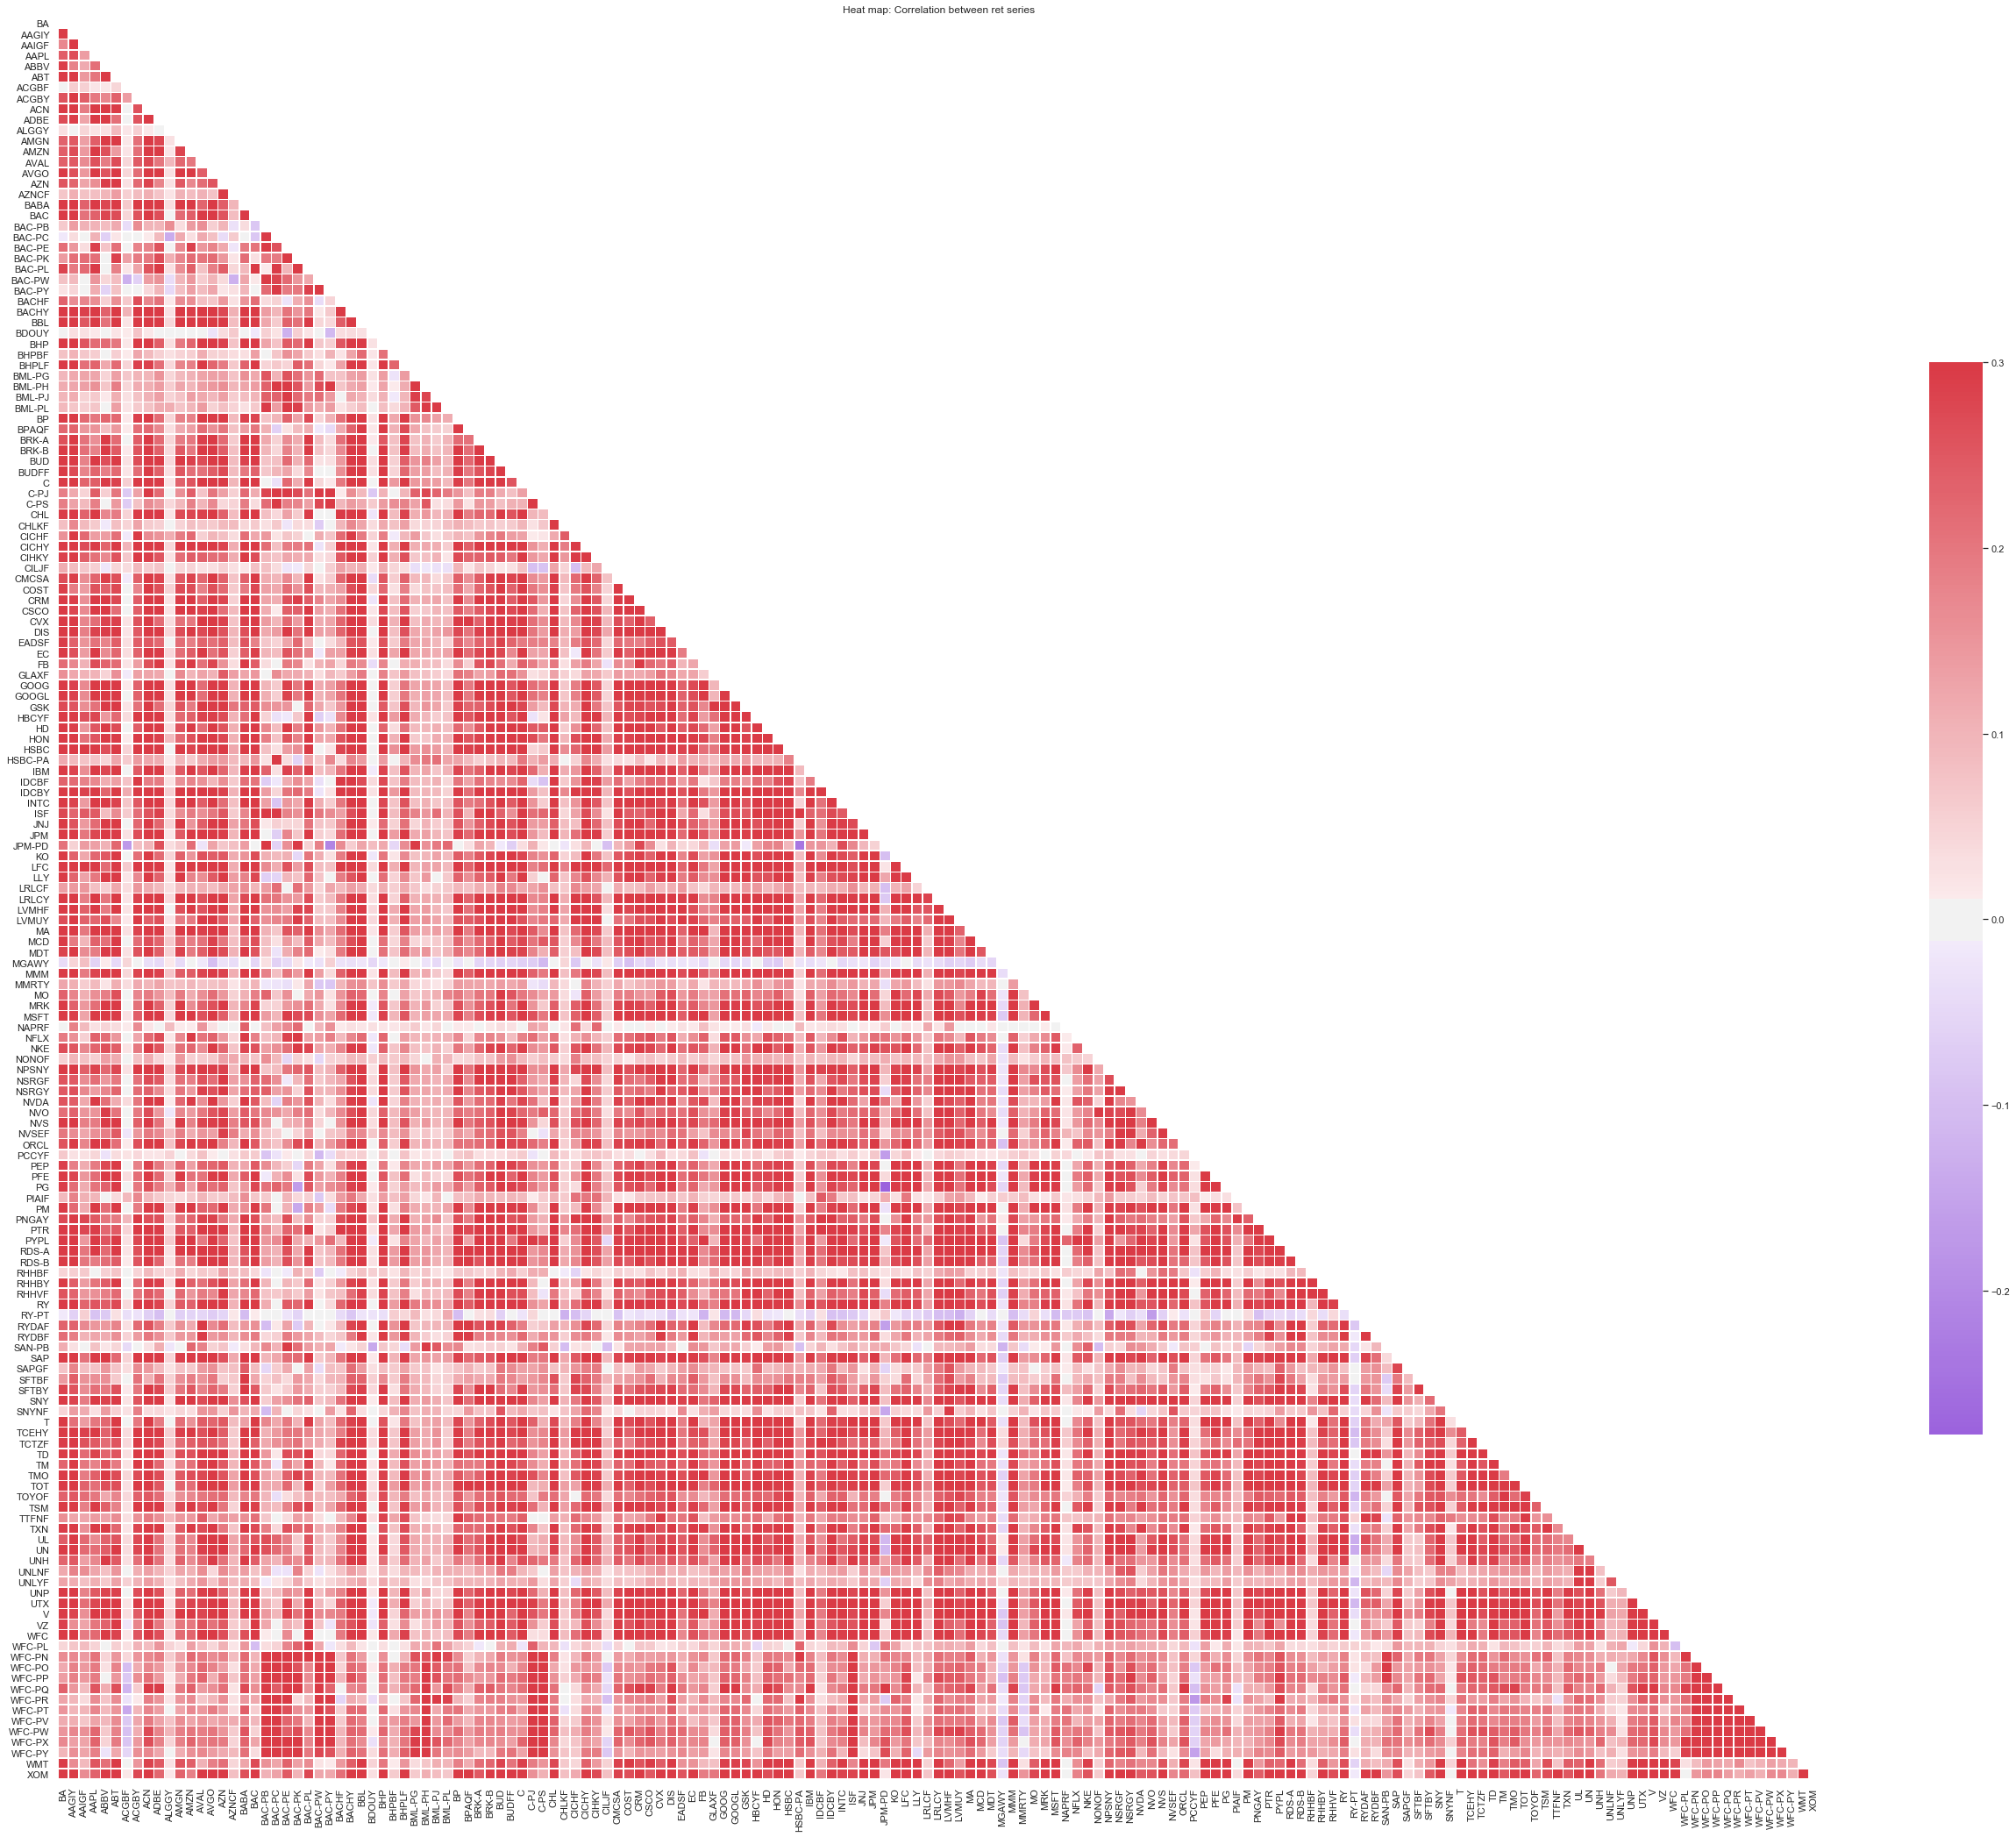

In [232]:
coor_mat('ret')

In [233]:
returns.replace([-np.inf, np.inf], 0, inplace=True)

# Produire un ensemble de prédicteurs des returns en question
On fera bien attention à l'horizon de prédiction <br>
On essayera de produire au moins 1 predicteur faisant intervenir du Machine Learning <br>
On procédera à une analyse fine des autocorrelations <br>

On construira au moins 5 prédicteurs.


### Predictors
    -predictor n°1: KDE estimator
    -predictor n°2: Gaussian mixture model
    -predictor n°3: Autoregressive linear model
    -predictor n°4 Correlated Strategy
    -predictor n°5 Support Vector Machine regressor

In [235]:
# Run KDE for each series and compute score
from sklearn.neighbors import KernelDensity

def KDE(ret):
    kdes = []
    for series in ret:
        series = ret[series].dropna().values.reshape(-1,1)
        kde = KernelDensity().fit(series).score(series)
        kdes.append(kde)
    return kdes

kdes = KDE(returns)

print('The mean score of all Kernel Density Estimators predictors is: {}.'.format(np.mean(kdes)))

The mean score of all Kernel Density Estimators predictors is: -6642.415769015535.


In [236]:
# Run GMM on each series with component from 1 to 20
# save the best score with its number of components
# return list of best scores with the number of components.
from sklearn.mixture import GaussianMixture

def GMM(ret):
    components = range(30, 60)
    gmms = []
    for series in ret:
        series = ret[series].dropna().values.reshape(-1,1)
        scores = {}
        for c in components:
            reg = GaussianMixture(n_components=c, covariance_type='full').fit(series).score(series)
            scores[c] = reg
        gmms.append(max(scores.items(), key=operator.itemgetter(1)))
    return gmms

gmms = GMM(returns)

In [237]:
gmms_scores = [score[1] for score in gmms]

print('The mean on all Gaussian Mixture Models scores is: {}'.format(np.mean(gmms_scores)))

The mean on all Gaussian Mixture Models scores is: -0.4090421722858577


In [238]:
# For each time series we create a matrix of more and more
# shifted values up to 75 days of difference
# We then regress our original time series with itself down 1 to 75 days back
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression()

def auto_regress(ret):
    scores = []
    for series in ret.columns:
        X = pd.DataFrame({n:returns[series].shift(n) for n in range(1,75)}).dropna()
        y = returns[series].loc[X.index]
        reg.fit(X,y)
        score = r2_score(y,reg.predict(X))
        scores.append(score)
    return scores

auto_regs = auto_regress(returns)

In [239]:
auto_reg = [x for x in auto_regs if type(x) is not float]
print('The mean on all Autoregressive Models R squared is: {}'.format(np.mean(auto_reg)))

The mean on all Autoregressive Models R squared is: 0.0981575853442755


### Autocorrelation analysis

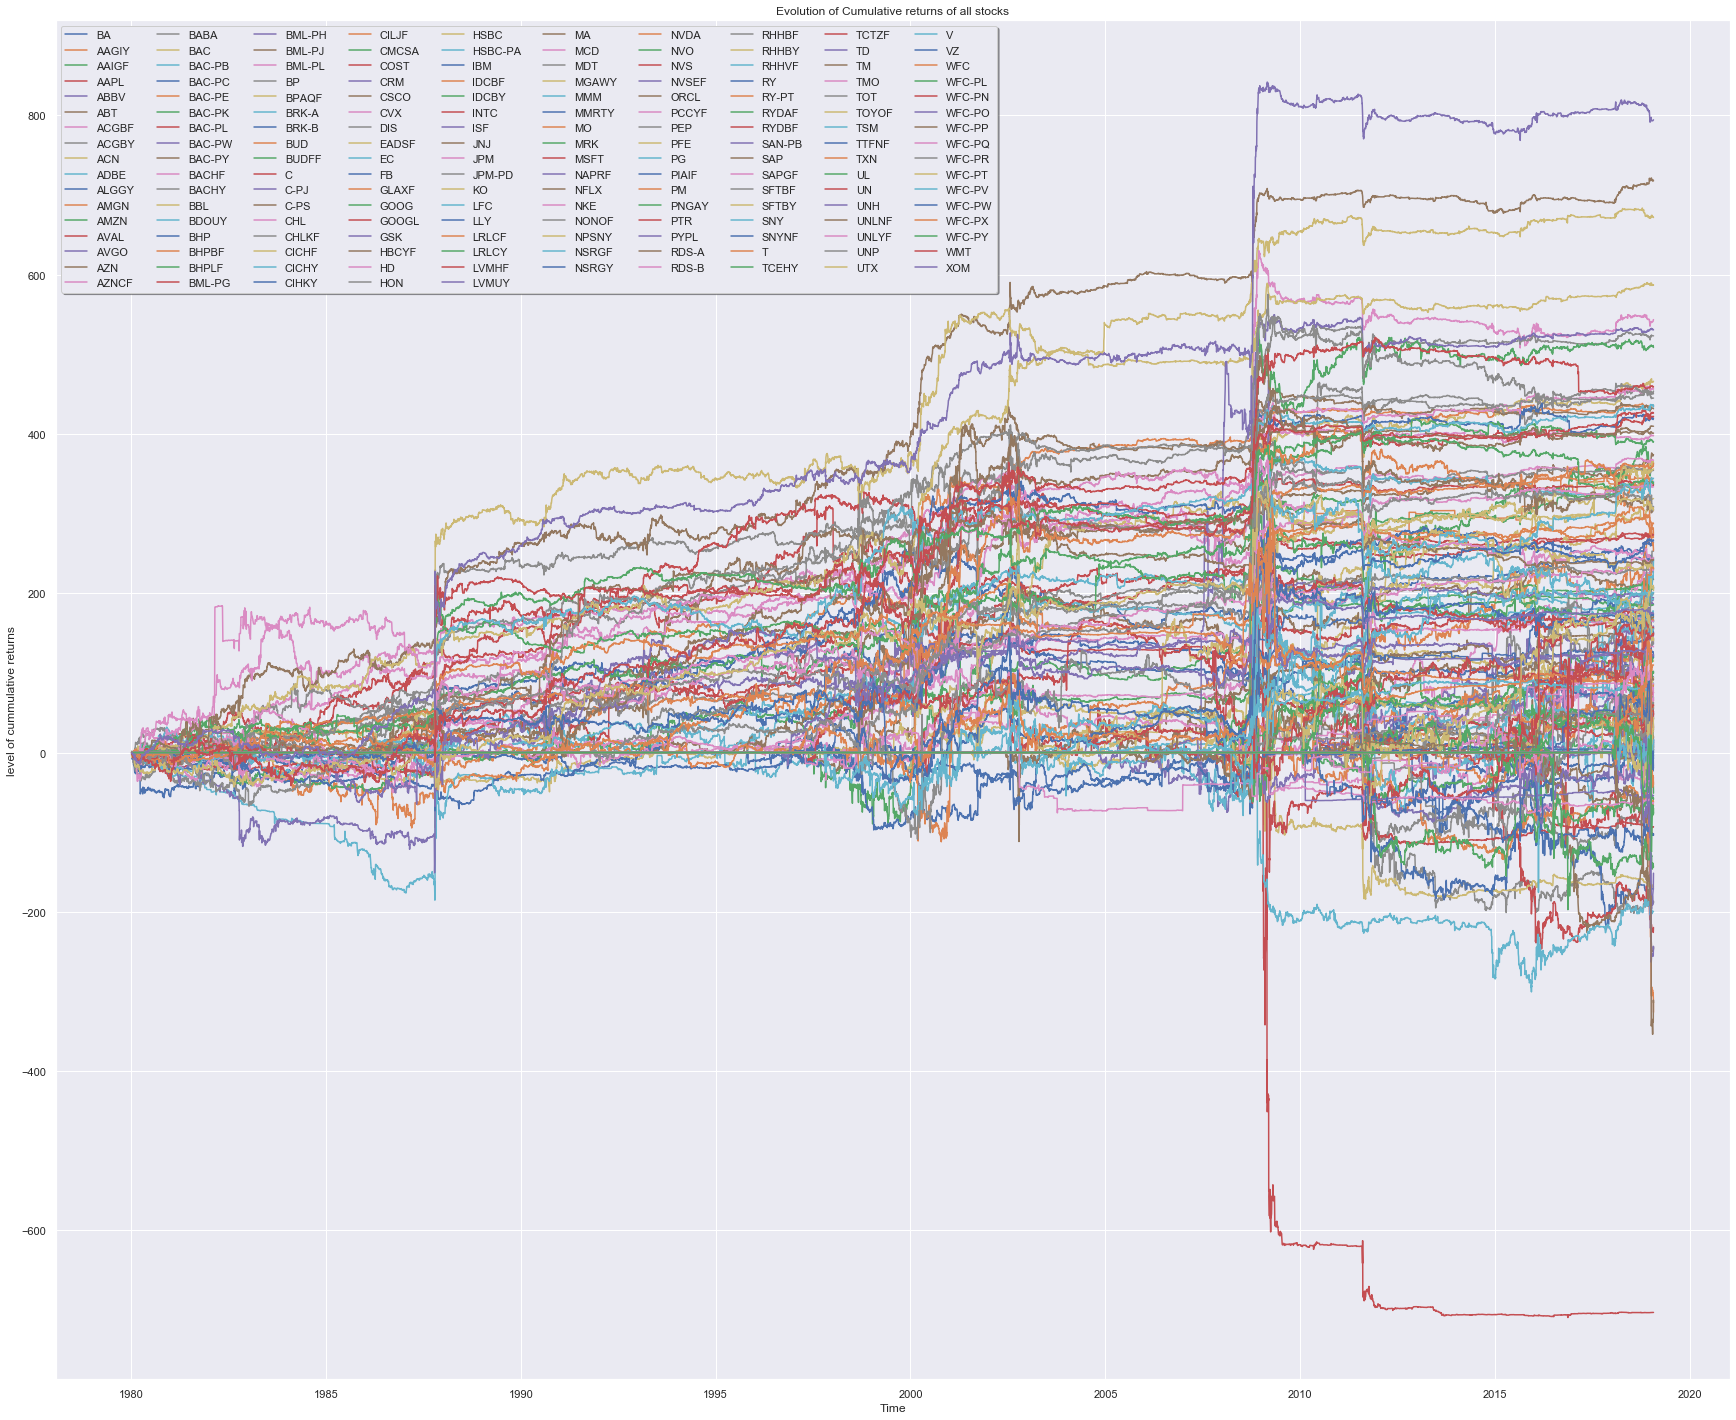

In [240]:
def corr_strat(series):
    series = (-series.shift(2) * series) / series.std()
    return series.cumsum()

cummulative_ret = returns.replace(np.nan, 0).apply(corr_strat, axis=0)
cummulative_ret.dropna(inplace=True)

sns.set_style("darkgrid")

fig = plt.figure(figsize=(30, 25))
ax = plt.subplot()
plt.title('Evolution of Cumulative returns of all stocks')
for series in cummulative_ret:
    ax.plot(cummulative_ret[series], label = series)
ax.legend(loc='upper left',
          ncol=10, fancybox=True, shadow=True)
plt.ylabel('level of cummulative returns')
plt.xlabel('Time')
plt.show()

In [241]:
from numba import njit

@njit()
def sharpe(series):
    return np.mean(series) / np.std(series) * np.sqrt(260)

@njit()
def get_rho(a,b):
    return np.corrcoef(a,b)[0][1]


sharpes = {}
for series in cummulative_ret:
    sharpes[series] = sharpe(cummulative_ret[series].values)
    
sharpes = sorted(sharpes.items(), key=lambda x: x[1])
sharpes = {item[0]:item[1] for item in sharpes}

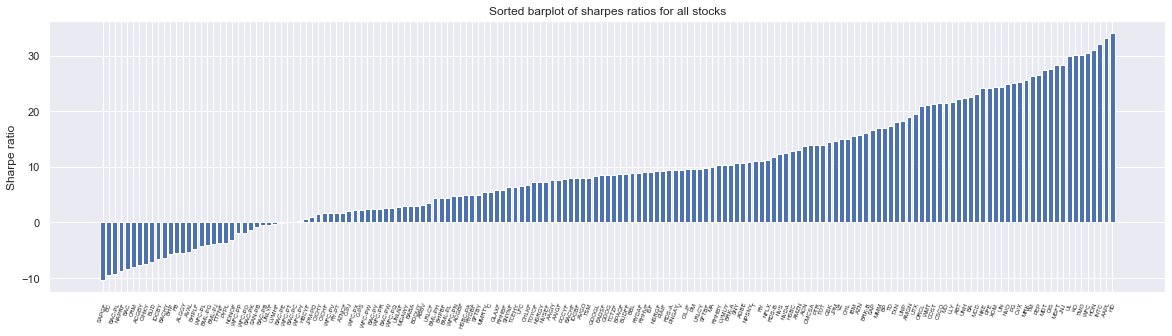

In [242]:
plt.figure(figsize=(20, 5))
plt.title('Sorted barplot of sharpes ratios for all stocks')
plt.bar(sharpes.keys(), sharpes.values())
plt.xticks(rotation=70, size=6)
plt.ylabel('Sharpe ratio')
plt.show()

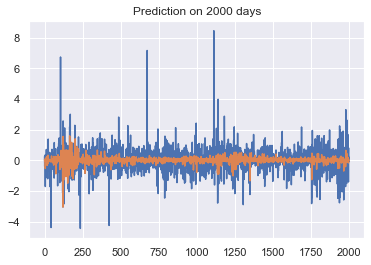

The overall score of the random forest model is 0.1729379172726302 on 2000 days of horizon


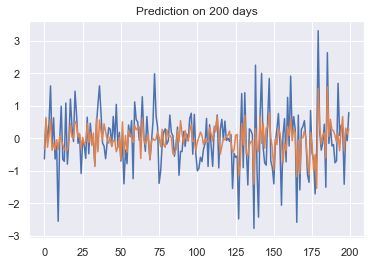

The overall score of the random forest model is 0.3938177793961349 on 200 days of horizon


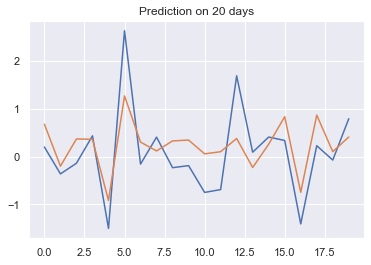

The overall score of the random forest model is 0.5162925688161677 on 20 days of horizon


In [243]:
from sklearn.ensemble import RandomForestRegressor

target = returns.GOOGL
features = returns.drop('GOOGL', axis=1)

features.dropna(axis=1, inplace=True)
target.replace([-np.inf, np.inf, np.nan], 0, inplace=True)

len_time = returns.values.shape[0]

def train(horizon):
    features['GOOGL'] = returns.GOOGL.shift(horizon)
    features.replace([-np.inf, np.inf, np.nan], 0, inplace=True)
    
    train_time = len_time - horizon
    
    y_train = target.head(train_time).values
    X_train = features.head(train_time).values

    y_test = target.tail(horizon).values
    X_test = features.tail(horizon).values
    
    features.drop('GOOGL', axis = 1, inplace=True)

    forest = RandomForestRegressor(n_estimators=150).fit(X_train, y_train)

    plt.title('Prediction on {} days'.format(horizon))
    plt.plot(y_test)
    plt.plot(forest.predict(X_test))
    plt.show()

    print("The overall score of the random forest model is {} on {} days of horizon".format(
        forest.score(X_test, y_test), horizon))

train(horizon=2000)
train(horizon=200)
train(horizon=20)

# Construire 3 portefeuilles Différents
A défaut on produira:
<br>
un portefeuille Markowitz <br>
un portefeuille 1/N<br>
un portefeuille issu d'une régression à partir des prédicteurs construits

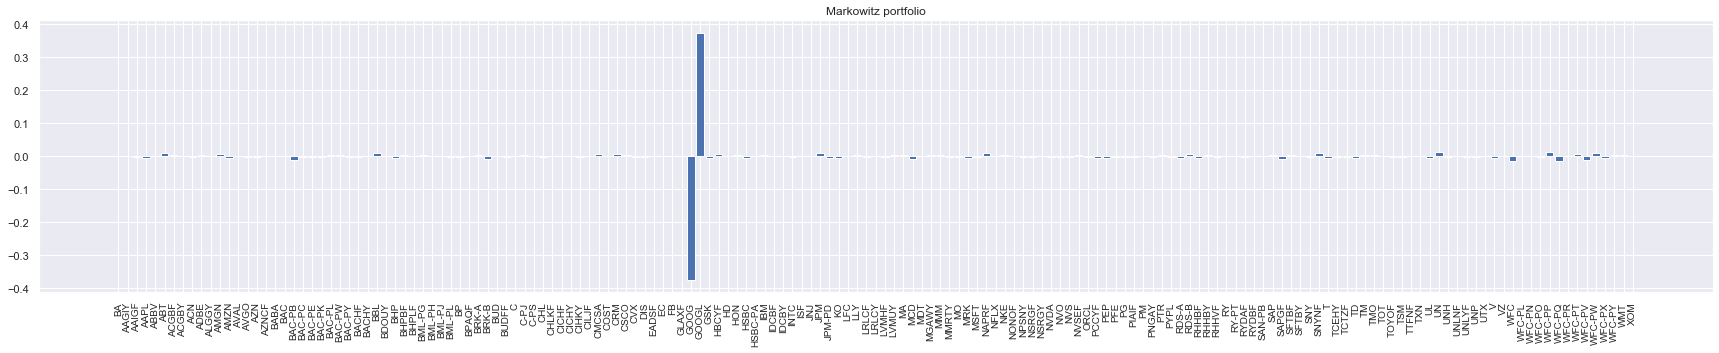

In [244]:
# Markowitz portfolio
from cvxopt import blas, solvers
import cvxopt as opt
import cvxpy as cvx
import cvxpy

def optimal_port(ret,risktg,POS=0):
    gain=ret.sum().values
    cvx_risks = cvx.Variable(ret.shape[1])
    cvx_objective = cvx.Maximize(cvx_risks.T * gain) 
    S=ret.cov()
    cvx_constraints = []
    
    cvx_constraints.append(cvx.quad_form(cvx_risks, S)<=risktg**2)
   
    cvx_prob = cvx.Problem(cvx_objective, cvx_constraints)
    cvx_constraints.append(cvx_risks>=-2)
    if POS:
        cvx_constraints.append(cvx_risks>=0)

    cvx_prob.solve(solver=cvx.SCS)
    return cvx_risks.value


markowitz_port = optimal_port(returns.replace(np.nan, 0), risktg=2, POS=False)

plt.figure(figsize=(30, 5))
plt.title('Markowitz portfolio')
plt.bar(returns.columns,markowitz_port)
plt.xticks(rotation=90, size=10)
plt.show()

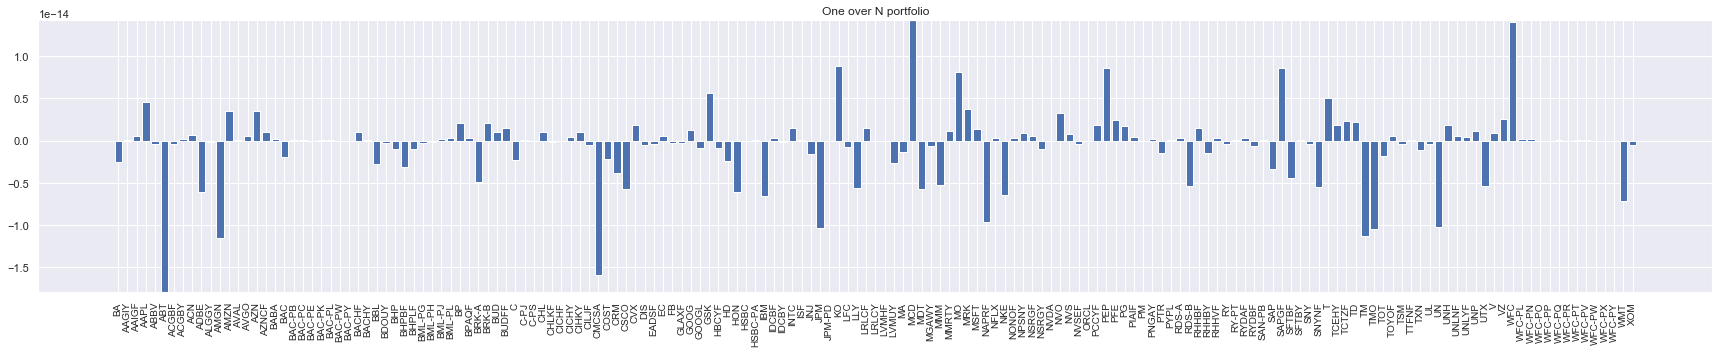

In [245]:
# 1/N porfolio
one_over_N_portfolio = returns.replace(np.nan, 0).sum()/len(returns.columns)
plt.figure(figsize=(30, 5))
plt.title('One over N portfolio')
plt.bar(returns.columns,one_over_N_portfolio)
plt.xticks(rotation=90, size=10)
plt.show()

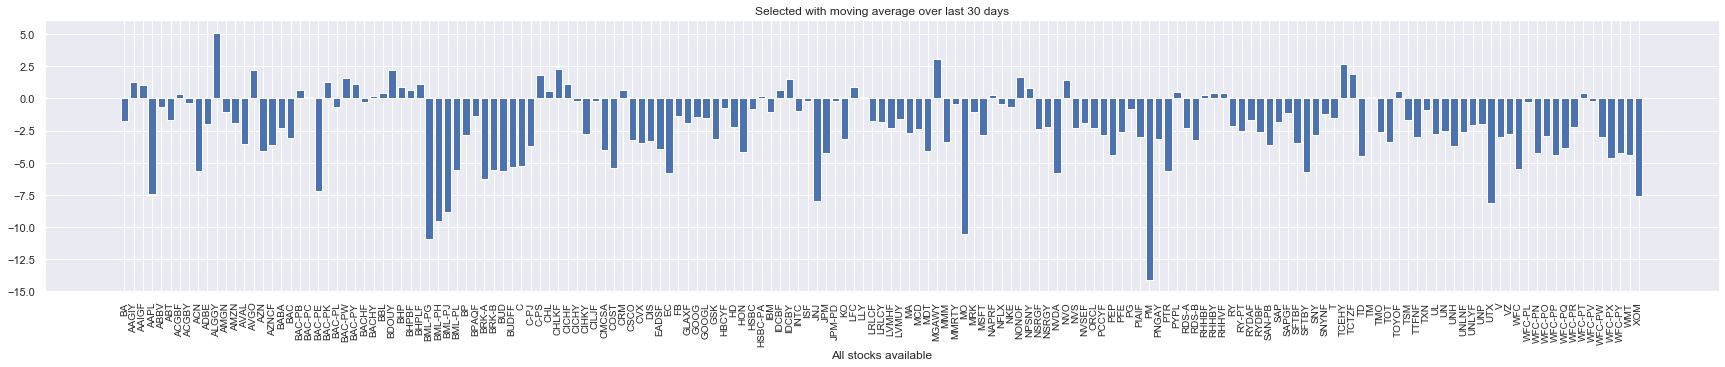

We select the N highest ranking stocks in last 30 days.

They have a high positive moving average meaning their stock is going up and we can expect this trend
to continue.


In [246]:
# Portfolio with moving average
from numba import njit, jit

@njit()
def moving_average(window_size, series):
    cumsum, moving_averages = [0], []
    for i,x in enumerate(series,1):
        cumsum.append(cumsum[i-1] + x)
        if i>=window_size:
            moving_average = (cumsum[i] - cumsum[i-window_size])/window_size
            moving_averages.append(moving_average)
    return moving_averages

@jit()
def select_stocks(returns):
    stocks = []
    for series in returns:
        stocks.append(np.sum(moving_average(30, returns[series].dropna().values)[-30:]))
    return stocks

selected_stocks = select_stocks(returns)

plt.figure(figsize=(30, 5))
plt.title('Selected with moving average over last 30 days')
plt.bar(returns.columns,selected_stocks)
plt.xlabel('All stocks available')
plt.xticks(rotation=90, size=10)
plt.show()

print('''We select the N highest ranking stocks in last 30 days.\n
They have a high positive moving average meaning their stock is going up and we can expect this trend
to continue.''')

## Aggreger l'ensemble des systèmes construits et analyser la performance globale